In [ ]:
# End-to-End E-Commerce Analytics & Churn Prediction
# ### From Raw Events to Business Decisions at Scale
# Author: Okai Tettey-Antie Samuel
# Platform:Google Colab
# Tools:Python, Pandas, Scikit-Learn, Kafka (Conceptual), Elasticsearch (Conceptual)

In [ ]:
# ============================================
# 0) SETUP
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import random
import warnings
warnings.filterwarnings("ignore")

# For ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
random.seed(42)

print("✅ Setup complete")


✅ Setup complete


In [ ]:
# ============================================
# 1) SYNTHETIC DATA GENERATION (FIXED)
# ============================================

import numpy as np
import pandas as pd
import random

N_CUSTOMERS = 5000
N_PRODUCTS  = 800
DAYS        = 180  # ~6 months

today = pd.Timestamp.utcnow().normalize()
start_date = today - pd.Timedelta(days=DAYS)

# Customers
customer_ids = [f"C{str(i).zfill(6)}" for i in range(N_CUSTOMERS)]
genders = ["Male", "Female"]
cities = ["Accra", "Kumasi", "Takoradi", "Tamale", "Cape Coast", "Tema"]
devices = ["Android", "iOS", "Web"]
acq_channels = ["Organic", "Paid Search", "Social", "Email", "Referral"]

customers = pd.DataFrame({
    "customer_id": customer_ids,
    "signup_date": pd.to_datetime(np.random.choice(pd.date_range(start_date, today), size=N_CUSTOMERS)),
    "age": np.clip(np.random.normal(30, 9, N_CUSTOMERS).round().astype(int), 18, 70),
    "gender": np.random.choice(genders, size=N_CUSTOMERS, p=[0.55, 0.45]),
    "city": np.random.choice(cities, size=N_CUSTOMERS, p=[0.35, 0.18, 0.12, 0.10, 0.10, 0.15]),
    "preferred_device": np.random.choice(devices, size=N_CUSTOMERS, p=[0.55, 0.25, 0.20]),
    "acquisition_channel": np.random.choice(acq_channels, size=N_CUSTOMERS, p=[0.35, 0.25, 0.15, 0.15, 0.10]),
})

# Products
categories = ["Electronics", "Fashion", "Home", "Beauty", "Sports", "Groceries"]
brands = [f"Brand_{i}" for i in range(60)]

products = pd.DataFrame({
    "product_id": [f"P{str(i).zfill(5)}" for i in range(N_PRODUCTS)],
    "category": np.random.choice(categories, size=N_PRODUCTS),
    "brand": np.random.choice(brands, size=N_PRODUCTS),
})

cat_price = {
    "Electronics": (200, 1500),
    "Fashion": (20, 200),
    "Home": (30, 400),
    "Beauty": (10, 150),
    "Sports": (25, 300),
    "Groceries": (2, 60),
}
products["price"] = products["category"].map(lambda c: round(np.random.uniform(*cat_price[c]), 2))

# Events
event_types = ["view", "add_to_cart", "purchase", "search", "wishlist"]

def poisson_sessions(acq):
    base = 8
    if acq in ["Paid Search", "Email"]:
        base = 10
    return np.random.poisson(base)

def choose_event_type(conv_boost: float):
    # Base probabilities (must sum to 1 after adjustment)
    # We'll "borrow" probability mass mainly from 'view' to boost 'purchase'
    base = np.array([0.60, 0.12, 0.04, 0.18, 0.06], dtype=float)  # sums to 1.0

    # Cap boost so we never go negative when subtracting from views
    boost = min(conv_boost, base[0] - 0.05)  # keep view prob at least 0.05

    base[2] += boost   # purchase
    base[0] -= boost   # view reduced

    # Normalize defensively (handles floating-point issues)
    base = np.clip(base, 0, None)
    base = base / base.sum()

    return np.random.choice(event_types, p=base)

rows = []
event_id = 0

for _, cust in customers.iterrows():
    n_sessions = poisson_sessions(cust["acquisition_channel"])
    signup = cust["signup_date"]
    active_days = max(1, (today - signup).days)

    for _s in range(n_sessions):
        session_day = signup + pd.Timedelta(days=np.random.randint(0, active_days))
        n_events = np.random.randint(3, 25)

        conv_boost = 0.02
        if cust["preferred_device"] == "Web":
            conv_boost += 0.01
        if cust["acquisition_channel"] == "Email":
            conv_boost += 0.02

        dominant_cat = np.random.choice(categories, p=[0.22, 0.20, 0.16, 0.14, 0.12, 0.16])
        pool = products.loc[products["category"] == dominant_cat, "product_id"].tolist()
        if len(pool) < 10:
            pool = products["product_id"].tolist()

        session_products = random.sample(pool, k=min(30, len(pool)))

        for _e in range(n_events):
            t = session_day + pd.Timedelta(minutes=np.random.randint(0, 1440))
            et = choose_event_type(conv_boost)
            pid = np.random.choice(session_products) if et in ["view", "add_to_cart", "purchase", "wishlist"] else None
            rows.append((event_id, cust["customer_id"], t, et, pid, cust["preferred_device"]))
            event_id += 1

events = pd.DataFrame(rows, columns=["event_id", "customer_id", "event_time", "event_type", "product_id", "device"])
events["event_time"] = pd.to_datetime(events["event_time"])

# Orders derived from purchase events
orders = events[events["event_type"] == "purchase"].copy()
orders = orders.merge(products[["product_id", "price", "category", "brand"]], on="product_id", how="left")
orders.rename(columns={"event_time": "order_time"}, inplace=True)
orders["quantity"] = np.random.choice([1, 1, 1, 2, 2, 3], size=len(orders))
orders["order_value"] = orders["price"] * orders["quantity"]

print("✅ Data generated")
print("customers:", customers.shape, "products:", products.shape, "events:", events.shape, "orders:", orders.shape)

customers.head()


✅ Data generated
customers: (5000, 7) products: (800, 4) events: (598131, 6) orders: (39241, 11)


,customer_id,signup_date,age,gender,city,preferred_device,acquisition_channel
0,C000000,2025-07-08 00:00:00+00:00,23,Male,Accra,Web,Paid Search
1,C000001,2025-10-25 00:00:00+00:00,23,Male,Tema,Android,Organic
2,C000002,2025-08-18 00:00:00+00:00,18,Male,Cape Coast,Android,Organic
3,C000003,2025-08-28 00:00:00+00:00,28,Male,Cape Coast,Android,Organic
4,C000004,2025-09-07 00:00:00+00:00,38,Female,Accra,Web,Social


Event distribution:
event_type
view           343028
search         107945
add_to_cart     71930
purchase        39241
wishlist        35987
Name: count, dtype: int64 



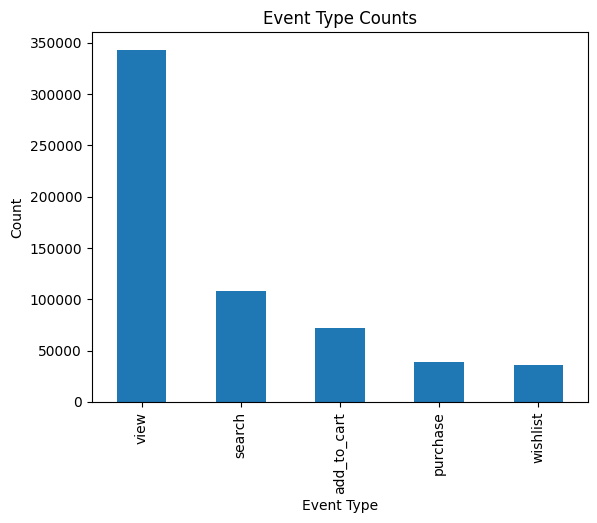

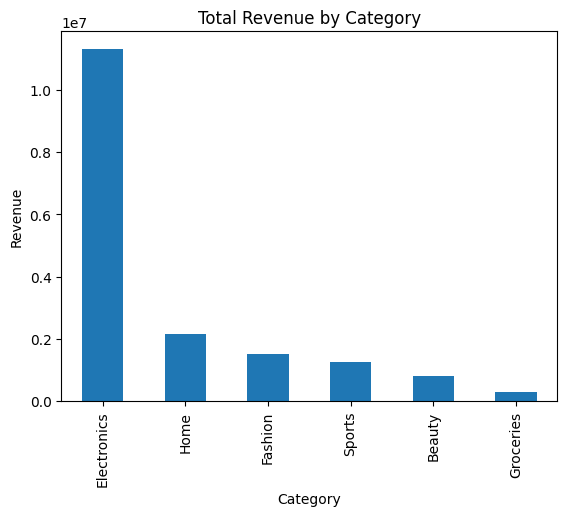

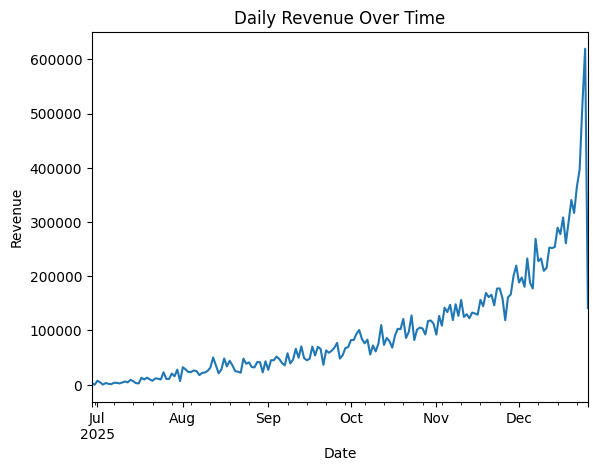

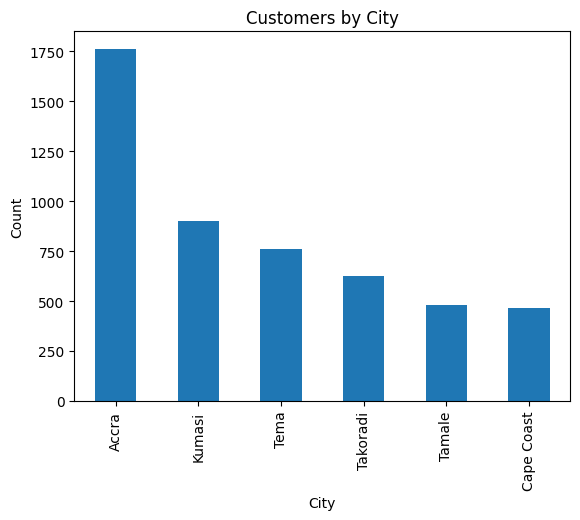

In [ ]:
# ============================================
# 2) EDA (Exploratory Data Analysis)
# ============================================

print("Event distribution:")
print(events["event_type"].value_counts(), "\n")

# Plot: event type counts
events["event_type"].value_counts().plot(kind="bar")
plt.title("Event Type Counts")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

# Plot: revenue by category
rev_by_cat = orders.groupby("category")["order_value"].sum().sort_values(ascending=False)
rev_by_cat.plot(kind="bar")
plt.title("Total Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.show()

# Plot: daily revenue
daily_rev = orders.set_index("order_time").resample("D")["order_value"].sum()
daily_rev.plot()
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# Plot: top cities by customers
customers["city"].value_counts().plot(kind="bar")
plt.title("Customers by City")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()


In [ ]:
# ============================================
# 3) DATA CLEANING
# ============================================

# Deduplicate events
before = len(events)
events = events.drop_duplicates(subset=["customer_id", "event_time", "event_type", "product_id"])
print("Duplicates dropped:", before - len(events))

# Ensure datetimes are clean
events["event_time"] = pd.to_datetime(events["event_time"], errors="coerce")
events = events.dropna(subset=["event_time"])

# Handle missing/invalid ages and prices (defensive coding)
customers["age"] = customers["age"].replace([np.inf, -np.inf], np.nan).fillna(customers["age"].median()).clip(18, 70)

products.loc[products["price"] < 0, "price"] = np.nan
products["price"] = products["price"].fillna(products["price"].median())

# Rebuild orders cleanly from cleaned events
orders = events[events["event_type"] == "purchase"].copy()
orders = orders.merge(products[["product_id", "price", "category", "brand"]], on="product_id", how="left")
orders.rename(columns={"event_time": "order_time"}, inplace=True)
orders["quantity"] = np.random.choice([1, 1, 1, 2, 2, 3], size=len(orders))
orders["order_value"] = orders["price"] * orders["quantity"]

print("✅ Cleaning complete. Shapes now:")
print("events:", events.shape, "orders:", orders.shape)


Duplicates dropped: 146
✅ Cleaning complete. Shapes now:
events: (597985, 6) orders: (39241, 11)


In [ ]:
# ============================================
# 4) FEATURE ENGINEERING + LABELING (CHURN)
# ============================================

end_time = events["event_time"].max()

cust_events = events.groupby("customer_id").agg(
    last_event_time=("event_time", "max"),
    total_events=("event_id", "count"),
    total_views=("event_type", lambda s: (s == "view").sum()),
    total_add_to_cart=("event_type", lambda s: (s == "add_to_cart").sum()),
    total_purchases=("event_type", lambda s: (s == "purchase").sum()),
    unique_products=("product_id", "nunique"),
    unique_days_active=("event_time", lambda s: s.dt.date.nunique()),
).reset_index()

cust_orders = orders.groupby("customer_id").agg(
    last_purchase_time=("order_time", "max"),
    total_spend=("order_value", "sum"),
    avg_order_value=("order_value", "mean"),
    total_items=("quantity", "sum"),
).reset_index()

df = customers.merge(cust_events, on="customer_id", how="left").merge(cust_orders, on="customer_id", how="left")

# Fill missing for users with no activity
fill_zero_cols = ["total_events","total_views","total_add_to_cart","total_purchases","unique_products",
                  "unique_days_active","total_spend","avg_order_value","total_items"]
for col in fill_zero_cols:
    df[col] = df[col].fillna(0)

# Recency features
df["days_since_last_event"] = (end_time - df["last_event_time"]).dt.days.fillna(DAYS)
df["days_since_last_purchase"] = (end_time - df["last_purchase_time"]).dt.days.fillna(DAYS)
df["days_since_signup"] = (end_time - df["signup_date"]).dt.days.clip(lower=0)

# Funnel rates
df["cart_rate"] = (df["total_add_to_cart"] / df["total_views"].replace(0, np.nan)).fillna(0)
df["purchase_rate"] = (df["total_purchases"] / df["total_add_to_cart"].replace(0, np.nan)).fillna(0)

# Churn label: no purchase in last 30 days
df["churn"] = (df["days_since_last_purchase"] > 30).astype(int)

print("✅ Feature engineering complete")
df[["customer_id","total_purchases","days_since_last_purchase","churn"]].head()


✅ Feature engineering complete


,customer_id,total_purchases,days_since_last_purchase,churn
0,C000000,20.0,7.0,0
1,C000001,9.0,2.0,0
2,C000002,6.0,44.0,1
3,C000003,8.0,33.0,1
4,C000004,10.0,19.0,0


Churn rate: 0.202 (20.2%)


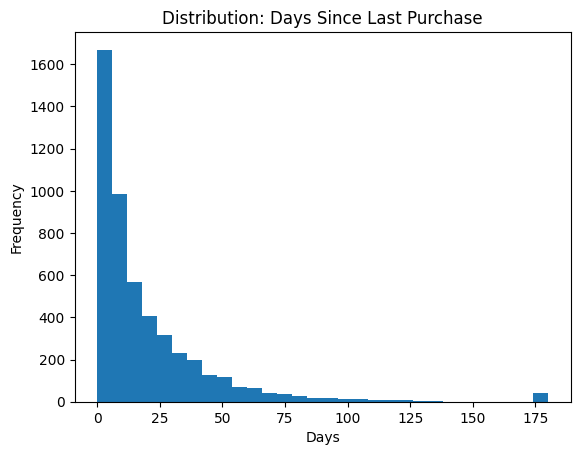

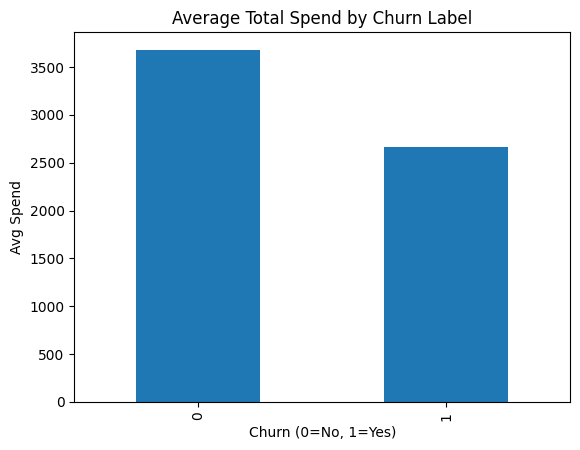

In [ ]:
# ============================================
# 5) SANITY CHECKS
# ============================================

churn_rate = df["churn"].mean()
print(f"Churn rate: {churn_rate:.3f} ({churn_rate*100:.1f}%)")

# Distribution of last purchase recency
df["days_since_last_purchase"].plot(kind="hist", bins=30)
plt.title("Distribution: Days Since Last Purchase")
plt.xlabel("Days")
plt.show()

# Compare average spend for churn vs non-churn
df.groupby("churn")["total_spend"].mean().plot(kind="bar")
plt.title("Average Total Spend by Churn Label")
plt.xlabel("Churn (0=No, 1=Yes)")
plt.ylabel("Avg Spend")
plt.show()


In [ ]:
# ============================================
# 6) MODELING (Pipelines + CV)
# ============================================

target = "churn"

cat_cols = ["gender", "city", "preferred_device", "acquisition_channel"]
num_cols = [
    "age","total_events","total_views","total_add_to_cart","total_purchases",
    "unique_products","unique_days_active","total_spend","avg_order_value","total_items",
    "days_since_last_event","days_since_last_purchase","cart_rate","purchase_rate","days_since_signup"
]

X = df[cat_cols + num_cols]
y = df[target]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in [("LogisticRegression", log_reg), ("RandomForest", rf)]:
    aucs = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
    print(f"{name} CV ROC-AUC: {aucs.mean():.4f} ± {aucs.std():.4f}")

print("✅ Modeling setup complete")


LogisticRegression CV ROC-AUC: 0.9998 ± 0.0001
RandomForest CV ROC-AUC: 1.0000 ± 0.0000
✅ Modeling setup complete


Test ROC-AUC: 1.0000

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       798
           1       1.00      1.00      1.00       202

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion matrix:
[[798   0]
 [  0 202]]


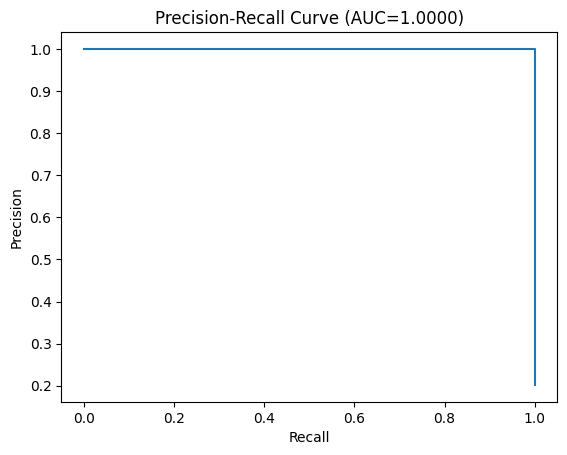

In [ ]:
# ============================================
# 7) FIT + EVALUATE
# ============================================

rf.fit(X_train, y_train)

proba = rf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, proba)
print(f"Test ROC-AUC: {roc:.4f}\n")

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, pred))

# Precision-Recall AUC (helpful for imbalance)
precision, recall, _ = precision_recall_curve(y_test, proba)
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


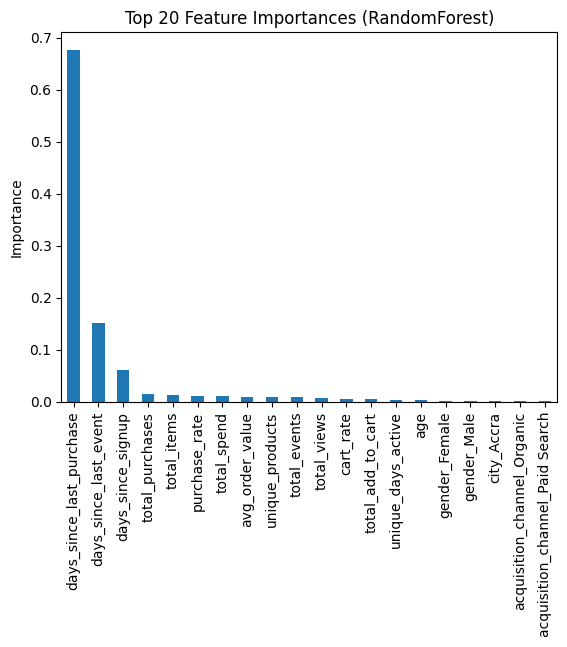

,0
days_since_last_purchase,0.676445
days_since_last_event,0.151405
days_since_signup,0.061558
total_purchases,0.015632
total_items,0.013828
purchase_rate,0.011603
total_spend,0.011145
avg_order_value,0.009572
unique_products,0.009039
total_events,0.008257


In [ ]:
# ============================================
# 8) EXPLAINABILITY (Feature Importances)
# ============================================

ohe = rf.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf.named_steps["model"].feature_importances_
imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

imp.plot(kind="bar")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.ylabel("Importance")
plt.show()

imp


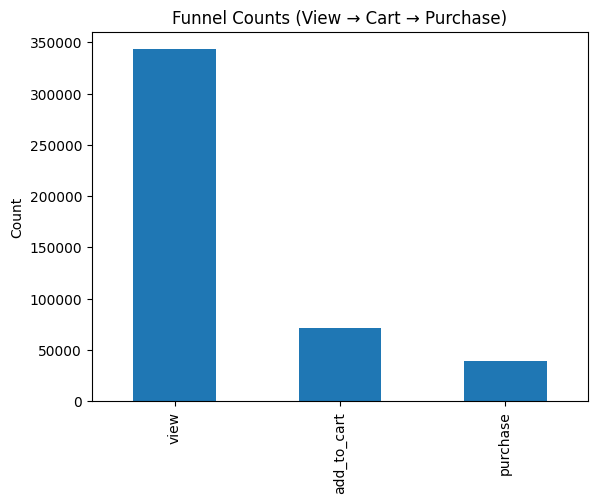

View → Cart rate: 0.20970568084082858
Cart → Purchase rate: 0.5455594483372261

Segment Summary:


,spender_segment,customers,churn_rate,avg_spend,avg_purchases
0,NoSpend,43,1.000000,0.000000,0.000000
1,Low,121,0.413223,113.595207,1.727273
2,Mid,557,0.296230,517.311741,3.827648
3,High,3090,0.189968,2549.033557,7.503236
4,VIP,1189,0.140454,7731.895172,11.534903



Top High-Risk & Valuable Customers:


,customer_id,city,acquisition_channel,total_spend,total_purchases,days_since_last_purchase,churn_risk
4594,C004594,Tema,Email,2269.61,6.0,42.0,0.996929
3149,C003149,Accra,Organic,3328.87,6.0,53.0,0.996046
278,C000278,Kumasi,Referral,892.56,2.0,45.0,0.995781
10,C000010,Accra,Paid Search,4817.66,8.0,55.0,0.993898
4320,C004320,Tema,Organic,5217.56,5.0,124.0,0.993857
2785,C002785,Tamale,Social,2473.72,5.0,86.0,0.993690
4298,C004298,Tema,Paid Search,2517.60,5.0,80.0,0.992851
4855,C004855,Accra,Paid Search,4039.53,7.0,48.0,0.992793
2493,C002493,Tema,Social,6534.85,7.0,54.0,0.992639
1674,C001674,Takoradi,Organic,3678.57,11.0,86.0,0.992631


In [ ]:
# ============================================
# 9) BUSINESS INSIGHTS
# ============================================

# Funnel counts
total_views = (events["event_type"]=="view").sum()
total_cart = (events["event_type"]=="add_to_cart").sum()
total_purchase = (events["event_type"]=="purchase").sum()

funnel = pd.Series({"view": total_views, "add_to_cart": total_cart, "purchase": total_purchase})
funnel.plot(kind="bar")
plt.title("Funnel Counts (View → Cart → Purchase)")
plt.ylabel("Count")
plt.show()

print("View → Cart rate:", total_cart / max(1, total_views))
print("Cart → Purchase rate:", total_purchase / max(1, total_cart))

# Spend segments
df["spender_segment"] = pd.cut(
    df["total_spend"],
    bins=[-1, 0, 200, 800, 5000, 1e12],
    labels=["NoSpend","Low","Mid","High","VIP"]
)

seg = df.groupby("spender_segment").agg(
    customers=("customer_id","count"),
    churn_rate=("churn","mean"),
    avg_spend=("total_spend","mean"),
    avg_purchases=("total_purchases","mean"),
).reset_index()

print("\nSegment Summary:")
display(seg)

# Score full dataset to create a churn-risk list
df_scored = df.copy()
df_scored["churn_risk"] = rf.predict_proba(df[cat_cols + num_cols])[:, 1]

high_risk_valuable = df_scored[(df_scored["churn_risk"] > 0.7) & (df_scored["total_spend"] > 300)] \
    .sort_values(["churn_risk","total_spend"], ascending=[False, False]) \
    .head(20)

print("\nTop High-Risk & Valuable Customers:")
display(high_risk_valuable[["customer_id","city","acquisition_channel","total_spend","total_purchases","days_since_last_purchase","churn_risk"]])


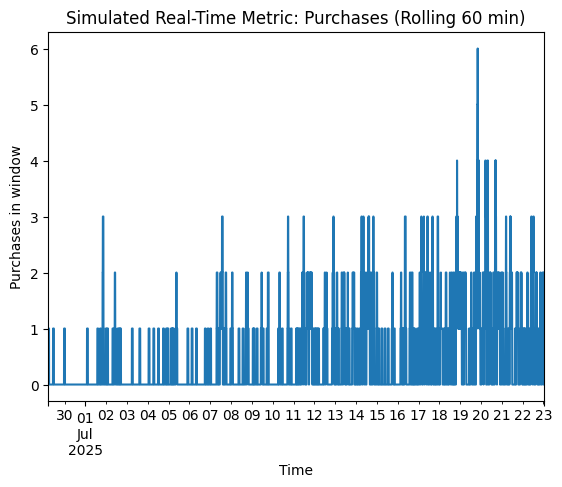

✅ Streaming simulation complete (Kafka-like).


In [ ]:
# ============================================
# 10) BIG DATA (Streaming Simulation - Colab Safe)
# ============================================

# We simulate a Kafka-like stream by emitting event messages in batches.
# In production: events → Kafka topic → consumers → storage/analytics systems.

stream = events.sort_values("event_time").head(5000).copy()

# Simulate a streaming consumer that aggregates real-time metrics
window_minutes = 60  # rolling window size
stream["event_time"] = pd.to_datetime(stream["event_time"])

# Create rolling counts per minute for purchases
purchases = stream[stream["event_type"] == "purchase"].copy()
per_min_purchase = purchases.set_index("event_time").resample("1min").size().rename("purchases_per_min")

# Rolling sum to mimic "dashboard metric"
rolling_purchase = per_min_purchase.rolling(window=f"{window_minutes}min").sum()

rolling_purchase.plot()
plt.title(f"Simulated Real-Time Metric: Purchases (Rolling {window_minutes} min)")
plt.xlabel("Time")
plt.ylabel("Purchases in window")
plt.show()

print("✅ Streaming simulation complete (Kafka-like).")


In [ ]:
# ============================================
# 11) EXPORT (Optional)
# ============================================

customers.to_csv("customers.csv", index=False)
products.to_csv("products.csv", index=False)
events.to_csv("events.csv", index=False)
orders.to_csv("orders.csv", index=False)
df.to_csv("customer_features.csv", index=False)

print("✅ Exported CSV files in Colab runtime:")
print("- customers.csv")
print("- products.csv")
print("- events.csv")
print("- orders.csv")
print("- customer_features.csv")


✅ Exported CSV files in Colab runtime:
- customers.csv
- products.csv
- events.csv
- orders.csv
- customer_features.csv
